# **Model and Feature Selection**

## Objectives
* Grid search to determine best candidate models.

* Validate or invalidate Hypothesis 1.

## Inputs
* Train and test datasets from the last notebook.

* Pipeline that was developed in the last notebook.

## Outputs
* A choice of classification model that we will further tune and evaluate.

## Additional Comments
* We have chosen to do classification rather than regression.

---

#### Change working directory

In [1]:
import os

home_dir = "/workspace/pp5-ml-dashboard"
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our training and test sets, as well as some of the packages that we will be using.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import get_df, save_df

train_dir = "datasets/train/classification"
X_TrainSet = get_df("X_TrainSet", train_dir)
y_TrainSet = get_df("y_TrainSet", train_dir)

test_dir = "datasets/test/classification"
X_TestSet = get_df("X_TestSet", test_dir)
y_TestSet = get_df("y_TestSet", test_dir)
all_columns = list(X_TrainSet.columns)


---

## Section 1: Full Pipeline
We will build the full pipeline here. It will accept parameters so that we can tune it. We also declare some constants that we established in the last notebook.

In [3]:
from sklearn.preprocessing import StandardScaler
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline


# Constants needed for feature engineering
META = ["season", "play_off"]
TRIVIAL = ["pts_home", "pts_away", "plus_minus_home"]
THRESH = 0.6
TRANSFORMS = {
    "log_e": (vt.LogTransformer, False),
    "log_10": (vt.LogTransformer, "10"),
    "reciprocal": (vt.ReciprocalTransformer, False),
    "power": (vt.PowerTransformer, False),
    "box_cox": (vt.BoxCoxTransformer, False),
    "yeo_johnson": (vt.YeoJohnsonTransformer, False),
}
TRANSFORM_ASSIGNMENTS = {
    "yeo_johnson": [
        "dreb_away",
        "blk_home",
        "oreb_away",
        "fta_away",
        "dreb_home",
        "ast_home",
        "stl_away",
        "pts_away",
        "stl_home",
        "reb_away",
        "pts_home",
        "fgm_away",
        "oreb_home",
        "pf_away",
        "pf_home",
    ],
    "box_cox": ["ast_away", "fta_home"],
}


def base_pipeline(to_drop=None):
    if not to_drop:
        to_drop = META
    else:
        to_drop.extend(META)
    to_drop = list(set(to_drop))
    pipeline = Pipeline(
        [
            ("dropper", DropFeatures(features_to_drop=to_drop)),
            (
                "corr_selector",
                SmartCorrelatedSelection(
                    method="pearson", threshold=THRESH, selection_method="variance"
                ),
            ),
        ]
    )
    pipeline.to_drop = to_drop
    return pipeline


def add_transformations(pipeline, transform_assignments):
    # This needs to be called after the above is fit so that the correlation selector has that attr
    to_drop = pipeline.to_drop
    dropping = set(to_drop + pipeline["corr_selector"].features_to_drop_)

    new_assignments = {
        key: [val for val in value if val not in dropping]
        for key, value in transform_assignments.items()
    }
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipeline.steps.append((transform, TRANSFORMS[transform][0](variables=targets)))
    pipeline.steps.append(("scaler", StandardScaler()))
    return pipeline

We add the last two steps of the pipeline, the feature selection and the model itself. We do this in a separate step since it depends on the model.

After a first pass, we will see that our models only use the features in `TRIVIAL`. These features make the classification problem too ... trivial as the winner of the game can be computed directly from features.

In [4]:
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

MODELS = {
    "LogisticRegression": LogisticRegression,
    "DecisionTree": DecisionTreeClassifier,
    "RandomForest": RandomForestClassifier,
    "GradientBoosting": GradientBoostingClassifier,
    "ExtraTrees": ExtraTreesClassifier,
    "AdaBoost": AdaBoostClassifier,
    "XGBoost": XGBClassifier,
}


def add_feat_selection_n_model(pipeline, model_name, random_state=42):
    model = MODELS[model_name](random_state=random_state)
    pipeline.steps.append(("feat_selection", SelectFromModel(model)))
    pipeline.steps.append((model_name, model))
    return pipeline

Let us now create our list of models that we are going to train.

In [5]:
def create_pipelines(to_drop=None):
    PIPELINES = {}
    for model_name in MODELS:
        base_pipe = base_pipeline(to_drop)
        base_pipe.fit(X_TrainSet)
        pipe_w_transforms = add_transformations(base_pipe, TRANSFORM_ASSIGNMENTS)
        PIPELINES[model_name] = add_feat_selection_n_model(
            pipe_w_transforms, model_name
        )
    return PIPELINES


PIPELINES = create_pipelines()

## Section 2: Cross Validation Search
We are going to perform multiple grid searchs as we refine our selection of features. The final grid search will determine the best model for our data, which we will tune in the next notebook.

Hypothesis 1 is that the models will gravitate strongly towards the features related to points. In order of estimated impact, they are:
* `'plus_minus'`
* `'pts'`
* `'fgm'`, `'fg3m'`, `'ftm'`

We will start by training our model on all of these features. To test this hypothesis, we will remove one collection of features at a time until we are left with no features that help you directly determine the winner. We will check which features the models use along the way to see if we can validate our hypothesis. We expect that the earlier models will be able to predict the outcome of the games flawlessly.

We won't be passing any parameters as we will tune the hyperparameters in the following notebook.

Note: we are silencing warnings below. These warnings generate  hundreds of lines and no exceptions are raised.

In [6]:
from sklearn.model_selection import GridSearchCV

# to suppress warnings
import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.captureWarnings(True)
os.environ["PYTHONWARNINGS"] = "ignore"


def grid_search(X_train, y_train, pipelines, param_grid={}):
    GRIDS = {}
    count = 0
    for pipe_name, pipe in pipelines.items():
        print(f"### Beginning grid search for {pipe_name} ###")
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=5,
            n_jobs=-2,
            verbose=3,
            scoring=["accuracy", "precision"],
            refit="precision",
        )
        grid.fit(X_train, y_train)
        GRIDS[pipe_name] = grid
        count += 1
        print(f"Finished with model {count}.")
        print(f"{len(pipelines.keys())-count} models remaining.")
    return GRIDS

### All features
We will now do a grid search using all features. We will then look at which features the models found most important.

In [7]:
GRIDS = grid_search(X_TrainSet, y_TrainSet, PIPELINES)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 3/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.1s
[CV 4/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.2s
[CV 1/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.1s
[CV 2/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.2s
[CV 5/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.1s
Finished with model 1.
6 models remaining.
### Beginning grid search for DecisionTree ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   0.9s
[CV 2/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   0.9s
[CV 4/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.0s
[CV 3/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   0.9s
[CV 1/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   0.9s
Finished with model 2.
5 models remaining

We see from the above that the models are "flawless." We will use the following code to generate reports for evaluating our models. You can pass one of the resulting pipelines to `'clf_performance'` or the whole grid to `'grid_search_report_best'` if you like.

In [10]:
from src.model_eval import clf_performance, get_best_scores, grid_search_report_best

print(GRIDS.keys())


def extract_best_estimator(grid_collection, model_name):
    return grid_collection[model_name].best_estimator_


def get_best_scores(grid_collection):
    for name, grid in grid_collection.items():
        res = (
            pd.DataFrame(grid.cv_results_)
            .sort_values(
                by=["mean_test_precision", "mean_test_accuracy"], ascending=False
            )
            .filter(["params", "mean_test_precision", "mean_test_accuracy"])
            .values
        )
        intro = f"Best {name} model:"
        print(f"{intro} Avg. Precision: {res[0][1]*100}%.")
        print(f"{len(intro)*' '} Avg. Accuracy: {res[0][2]*100}%.")
        print()


get_best_scores(GRIDS)

#grid_search_report_best(GRIDS,X_TrainSet,y_TrainSet,X_TestSet,y_TestSet,['loss','win'])

dict_keys(['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'ExtraTrees', 'AdaBoost', 'XGBoost'])
Best LogisticRegression model: Avg. Precision: 100.0%.
                               Avg. Accuracy: 100.0%.

Best DecisionTree model: Avg. Precision: 100.0%.
                         Avg. Accuracy: 100.0%.

Best RandomForest model: Avg. Precision: 100.0%.
                         Avg. Accuracy: 100.0%.

Best GradientBoosting model: Avg. Precision: 100.0%.
                             Avg. Accuracy: 100.0%.

Best ExtraTrees model: Avg. Precision: 100.0%.
                       Avg. Accuracy: 100.0%.

Best AdaBoost model: Avg. Precision: 100.0%.
                     Avg. Accuracy: 100.0%.

Best XGBoost model: Avg. Precision: 100.0%.
                    Avg. Accuracy: 100.0%.



Simply uncomment out the last line to look at a report for the best estimator of each type of model. There were 2 incorrect predictions, both made by the `ExtraTrees` model. This is as we expected. Let's inspect which features the models were trained on and which features the models dropped

Note that the plus/minus score and actual scores were still retained.
In the end, each model was only trained an the following features.

In [15]:
def find_features(X_train, fitted_pipe, initial_drop):
    total = len(X_train.columns)
    corr_dropped = list(fitted_pipe["corr_selector"].features_to_drop_)
    auto_dropped = initial_drop + corr_dropped
    cols = [col for col in X_train.columns if col not in auto_dropped]

    features = fitted_pipe["feat_selection"].get_support()
    X = X_train.filter(cols)
    if len(X.columns) != features.shape[0]:
        raise ValueError
    feat_selected_dropped = []
    feat_selected = []
    for index, col in enumerate(X.columns):
        if not features[index]:
            X.drop(col, axis=1, inplace=True)
            feat_selected_dropped.append(col)
        else:
            feat_selected.append(col)
    dropped = set(auto_dropped + feat_selected_dropped)
    kept = set(X.columns)
    if set.intersection(dropped, kept):
        raise ValueError(str(set.intersection(dropped, kept)))
    missing = [col for col in X_train.columns 
               if col not in set.union(dropped, kept)]
    if missing:
        raise ValueError(str(missing))
    if total != len(kept) + len(dropped):
        raise ValueError(str(total - len(kept) - len(dropped)))
    return list(X.columns), auto_dropped + feat_selected_dropped


def find_overlaps(best_pipes, initial_drop):
    list_of_feat_sets = [
        set(find_features(X_TrainSet, pipe, initial_drop)[0])
        for pipe in best_pipes.values()
    ]
    overlap_kept = set.intersection(*list_of_feat_sets)
    list_of_not_feat_sets = [
        set(find_features(X_TrainSet, pipe, initial_drop)[1])
        for pipe in best_pipes.values()
    ]
    overlap_dropped = set.intersection(*list_of_not_feat_sets)
    overlap_dropped = set.difference(overlap_dropped, set(META))
    return overlap_kept, overlap_dropped


def drop_report(grid_collection, X, initial_drop):
    best_pipes = {name: grid.best_estimator_ 
                  for name, grid in grid_collection.items()}
    for pipe_name, pipe in best_pipes.items():
        print(pipe_name, "used:")
        kept, _ = find_features(X, pipe, initial_drop)
        print(kept)
        sample_pipe = pipe
        print()

    overlap_kept, overlap_dropped = find_overlaps(best_pipes, initial_drop)
    print(f"All models used: \n{overlap_kept}.")
    print(f"All models dropped: \n{overlap_dropped}.")
    print()
    print(
        f"The SmartCorrelatedSelection step dropped:"
        f"\n{sample_pipe['corr_selector'].features_to_drop_}."
    )


drop_report(GRIDS, X_TrainSet, META)

LogisticRegression used:
['pts_home', 'plus_minus_home', 'pts_away']

DecisionTree used:
['plus_minus_home']

RandomForest used:
['pts_home', 'plus_minus_home', 'pts_away']

GradientBoosting used:
['plus_minus_home']

ExtraTrees used:
['pts_home', 'plus_minus_home', 'pts_away']

AdaBoost used:
['plus_minus_home']

XGBoost used:
['plus_minus_home']

All models used: 
{'plus_minus_home'}.
All models dropped: 
{'ftm_home', 'dreb_away', 'fg3a_away', 'tov_home', 'tov_away', 'fg3m_away', 'ftm_away', 'oreb_away', 'ast_away', 'fgm_home', 'fga_away', 'stl_home', 'pf_away', 'reb_home', 'oreb_home', 'reb_away', 'fg3a_home', 'pf_home', 'blk_away', 'blk_home', 'stl_away', 'ast_home', 'fgm_away', 'dreb_home', 'fg3m_home', 'fta_home', 'fta_away', 'fga_home'}.

The SmartCorrelatedSelection step dropped:
['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'ast_home', 'stl_home', 'pf_home', 'fgm_away', 'fg3a_away', 'ftm_away', 'dreb_away', 'ast_away', 'stl_away', 'pf_away'].


This a large step towards validating our first hypothesis. Let's remove `'plus_minus_home'` and see how this impacts the models.


### Removing plus/minus score

In [12]:
PIPELINES_wo_pm = create_pipelines(to_drop=["plus_minus_home"])
GRIDS_wo_pm = grid_search(X_TrainSet, y_TrainSet, PIPELINES_wo_pm)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.0s
[CV 5/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.1s
[CV 4/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.0s
[CV 1/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.0s
[CV 3/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   0.9s
Finished with model 1.
6 models remaining.
### Beginning grid search for DecisionTree ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END . accuracy: (test=0.999) precision: (test=0.999) total time=   1.1s
[CV 3/5] END . accuracy: (test=0.999) precision: (test=1.000) total time=   1.1s
[CV 1/5] END . accuracy: (test=1.000) precision: (test=1.000) total time=   1.1s
[CV 2/5] END . accuracy: (test=0.999) precision: (test=1.000) total time=   1.1s
[CV 5/5] E

This grid search took noticeably longer than the other one. Unsurprisingly, these models also performed extremely well. `AdaBoost` was the 'worst' performing model.

In [13]:
get_best_scores(GRIDS_wo_pm)

print("### Best AdaBoost model ###")
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    GRIDS_wo_pm["AdaBoost"].best_estimator_,
    ["loss", "win"],
)

Best LogisticRegression model: Avg. Precision: 100.0%.
                               Avg. Accuracy: 100.0%.

Best DecisionTree model: Avg. Precision: 99.94809538713346%.
                         Avg. Accuracy: 99.9455205353326%.

Best RandomForest model: Avg. Precision: 99.96697000239465%.
                         Avg. Accuracy: 99.96845919239748%.

Best GradientBoosting model: Avg. Precision: 99.91977346807073%.
                             Avg. Accuracy: 99.91398096083654%.

Best ExtraTrees model: Avg. Precision: 99.98584349176355%.
                       Avg. Accuracy: 99.9885308769853%.

Best AdaBoost model: Avg. Precision: 98.77393315282352%.
                     Avg. Accuracy: 98.75272393212981%.

Best XGBoost model: Avg. Precision: 99.9245127201237%.
                    Avg. Accuracy: 99.92544926178027%.

### Best AdaBoost model ###
#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       13341        348
Prediction win      

Let's see what features were removed and what our models were trained on.

In [14]:
initial_drop_wo_pm = ["plus_minus_home"] + META
drop_report(GRIDS_wo_pm, X_TrainSet, initial_drop_wo_pm)

LogisticRegression used:
['pts_home', 'pts_away']

DecisionTree used:
['pts_home', 'pts_away']

RandomForest used:
['pts_home', 'pts_away']

GradientBoosting used:
['pts_home', 'pts_away']

ExtraTrees used:
['pts_home', 'pts_away']

AdaBoost used:
['pts_home', 'pts_away']

XGBoost used:
['pts_home', 'pts_away']

All models used: 
{'pts_away', 'pts_home'}.
All models dropped: 
{'ftm_home', 'dreb_away', 'fg3a_away', 'tov_home', 'tov_away', 'fg3m_away', 'ftm_away', 'oreb_away', 'plus_minus_home', 'ast_away', 'fgm_home', 'fga_away', 'stl_home', 'pf_away', 'reb_home', 'oreb_home', 'reb_away', 'fg3a_home', 'pf_home', 'blk_away', 'blk_home', 'stl_away', 'ast_home', 'fgm_away', 'dreb_home', 'fg3m_home', 'fta_home', 'fta_away', 'fga_home'}.

The SmartCorrelatedSelection step dropped:
['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'ast_home', 'stl_home', 'pf_home', 'fgm_away', 'fg3a_away', 'ftm_away', 'dreb_away', 'ast_away', 'stl_away', 'pf_away'].


As expected, they focused completely on the points scored by each team. Despite this, there were some models that made incorrect predictions. Let's go further and remove the points each team scored.

### Remove points
Now we remove the scores that each team got and run the search again.

In [16]:
PIPELINES_wo_pts = create_pipelines(to_drop=TRIVIAL)
GRIDS_wo_pts = grid_search(X_TrainSet, y_TrainSet, PIPELINES_wo_pts)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END . accuracy: (test=0.926) precision: (test=0.941) total time=   0.7s
[CV 2/5] END . accuracy: (test=0.918) precision: (test=0.929) total time=   0.7s
[CV 3/5] END . accuracy: (test=0.930) precision: (test=0.935) total time=   0.7s
[CV 4/5] END . accuracy: (test=0.925) precision: (test=0.937) total time=   0.8s
[CV 5/5] END . accuracy: (test=0.924) precision: (test=0.934) total time=   0.8s
Finished with model 1.
6 models remaining.
### Beginning grid search for DecisionTree ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END . accuracy: (test=0.846) precision: (test=0.878) total time=   1.1s
[CV 3/5] END . accuracy: (test=0.842) precision: (test=0.870) total time=   1.2s
[CV 2/5] END . accuracy: (test=0.839) precision: (test=0.873) total time=   1.2s
[CV 5/5] END . accuracy: (test=0.851) precision: (test=0.881) total time=   1.2s
[CV 4/5] E

This made it slightly more challenging for the models. Don't forget that they still had access to made field goals, free throws, and 3 pointers. They could compute the score form this information. From earlier models, we know that the Smart Correlated Selector often threw out some of these features as they were highly correlated with attempted shots as well as total points. Lets see what the best performance was and which features the models trained on.

In [17]:
get_best_scores(GRIDS_wo_pts)

Best LogisticRegression model: Avg. Precision: 93.52878382209546%.
                               Avg. Accuracy: 92.46759519581731%.

Best DecisionTree model: Avg. Precision: 87.54237760880497%.
                         Avg. Accuracy: 84.47069193712802%.

Best RandomForest model: Avg. Precision: 90.02650778547618%.
                         Avg. Accuracy: 88.32435467429548%.

Best GradientBoosting model: Avg. Precision: 89.1064473985692%.
                             Avg. Accuracy: 89.10138272335668%.

Best ExtraTrees model: Avg. Precision: 89.26430022591%.
                       Avg. Accuracy: 88.51358472263327%.

Best AdaBoost model: Avg. Precision: 90.0707350925453%.
                     Avg. Accuracy: 88.98096618000066%.

Best XGBoost model: Avg. Precision: 90.96801229981472%.
                    Avg. Accuracy: 89.50853474071883%.



The Decision Tree model was the worst and the Logistic Regression was the best. Let's look at the reports of each.

In [18]:
target_names = ["LogisticRegression", "DecisionTree"]
two_grids = {name: grid for name, grid in GRIDS_wo_pts.items() 
             if name in target_names}
grid_search_report_best(
    two_grids, X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, ["loss", "win"]
)

LogisticRegression
#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       12305       1384
Prediction win         1236      19951


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.91      0.90      0.90     13689
         win       0.94      0.94      0.94     21187

    accuracy                           0.92     34876
   macro avg       0.92      0.92      0.92     34876
weighted avg       0.92      0.92      0.92     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        3142        349
Prediction win          308       4920


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.91      0.90      0.91      3491
         win       0.93      0.94      0.94      5228

    accuracy                           0.92      8719
   macro avg       0.92      0.92   

These are both very good models. The `DecisionTree` model has an average precision of 84% and an accuracy of 85%. This is well above the desired 75% and 70%, respectively.

In [19]:
initial_drop_wo_pts = TRIVIAL + META
drop_report(GRIDS_wo_pts, X_TrainSet, initial_drop_wo_pts)

LogisticRegression used:
['fgm_home', 'fg3a_home', 'fta_home', 'fgm_away', 'fg3m_away', 'fta_away']

DecisionTree used:
['fgm_home', 'fta_home', 'fgm_away', 'fta_away']

RandomForest used:
['fgm_home', 'fta_home', 'fgm_away', 'fta_away']

GradientBoosting used:
['fgm_home', 'fta_home', 'fgm_away', 'fta_away']

ExtraTrees used:
['fgm_home', 'fta_home', 'reb_home', 'fgm_away', 'fta_away', 'reb_away']

AdaBoost used:
['fgm_home', 'fta_home', 'fgm_away', 'fta_away']

XGBoost used:
['fgm_home', 'fta_home', 'fgm_away', 'fta_away']

All models used: 
{'fgm_home', 'fta_home', 'fgm_away', 'fta_away'}.
All models dropped: 
{'ftm_home', 'dreb_away', 'fg3a_away', 'tov_home', 'tov_away', 'ftm_away', 'oreb_away', 'plus_minus_home', 'ast_away', 'fga_away', 'pf_away', 'pts_home', 'oreb_home', 'pts_away', 'pf_home', 'blk_away', 'blk_home', 'stl_away', 'ast_home', 'dreb_home', 'fg3m_home', 'stl_home', 'fga_home'}.

The SmartCorrelatedSelection step dropped:
['fg3m_home', 'ftm_home', 'dreb_home', 'ast_ho

DecisionTree
* These are the 4 most important features in descending order. The model was trained on them: 
['fgm_away', 'fgm_home', 'fta_home', 'fta_away']


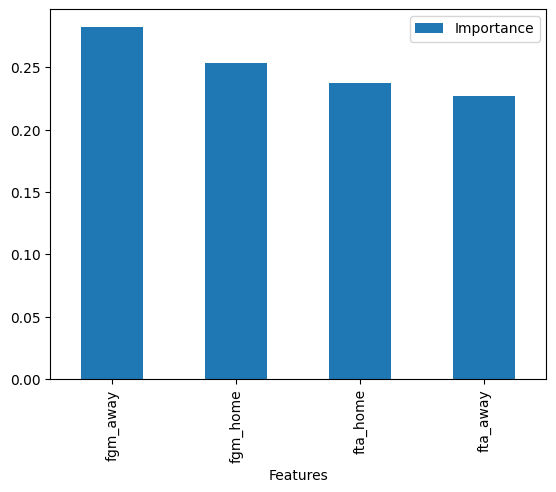

RandomForest
* These are the 4 most important features in descending order. The model was trained on them: 
['fgm_away', 'fgm_home', 'fta_home', 'fta_away']


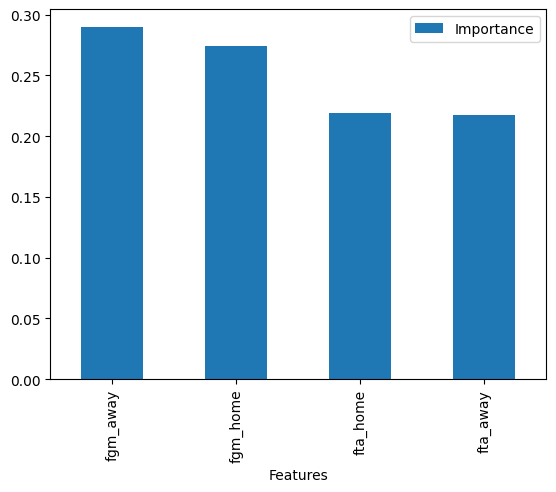

GradientBoosting
* These are the 4 most important features in descending order. The model was trained on them: 
['fgm_away', 'fgm_home', 'fta_home', 'fta_away']


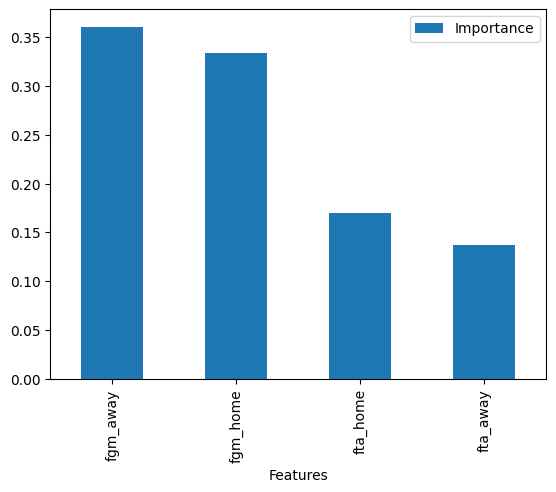

ExtraTrees
* These are the 6 most important features in descending order. The model was trained on them: 
['fgm_home', 'fgm_away', 'fta_home', 'fta_away', 'reb_home', 'reb_away']


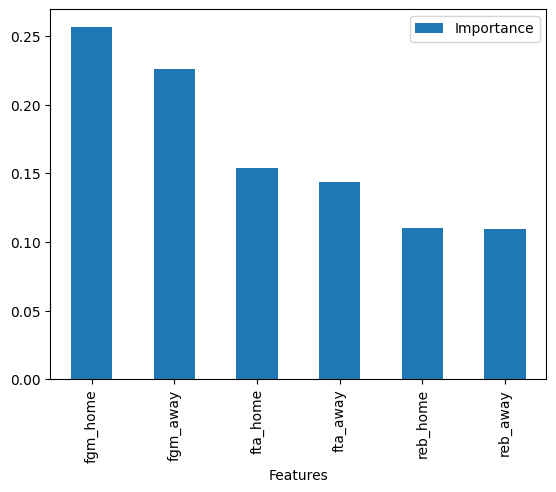

AdaBoost
* These are the 4 most important features in descending order. The model was trained on them: 
['fgm_home', 'fgm_away', 'fta_home', 'fta_away']


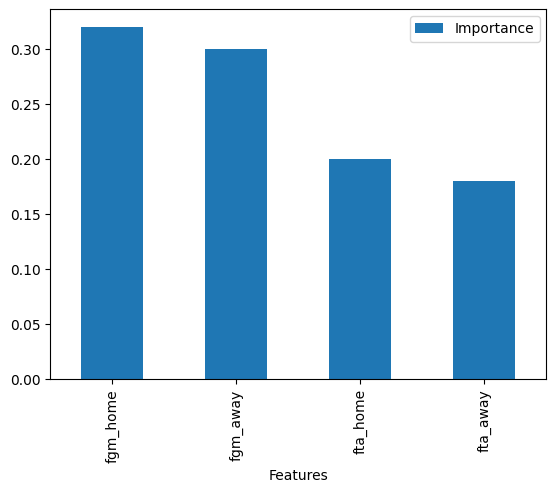

XGBoost
* These are the 4 most important features in descending order. The model was trained on them: 
['fgm_away', 'fgm_home', 'fta_home', 'fta_away']


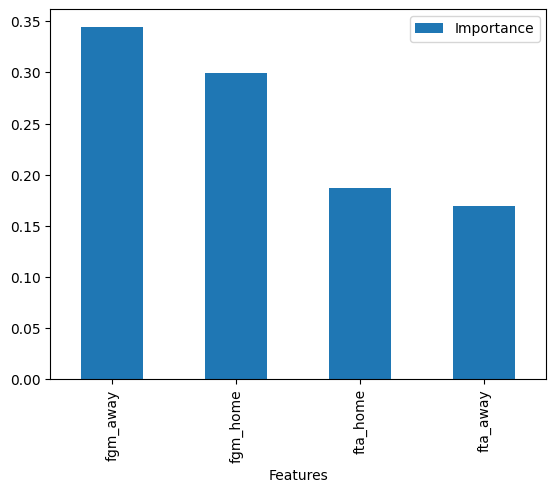

In [20]:
# This code is from Unit 04 of the Scikit-Learn lessons
def feature_importance_tree_based_models(model, columns):
    df_feature_importance = pd.DataFrame(
        data={"Features": columns, "Importance": model.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    best_features = df_feature_importance["Features"].to_list()

    # Most important features statement and plot
    print(
        f"* These are the {len(best_features)} most important features in "
        f"descending order. The model was trained on them: \n"
        f"{df_feature_importance['Features'].to_list()}"
    )

    df_feature_importance.plot(kind="bar", x="Features", y="Importance")
    plt.show()


def important_feature_report(grid_collection, X_train, initial_drop):
    best_pipes = {name: grid.best_estimator_ 
                  for name, grid in grid_collection.items()}
    for pipe_name, pipe in best_pipes.items():
        if pipe_name == "LogisticRegression":
            continue
        print(pipe_name)
        kept, _ = find_features(X_train, pipe, initial_drop)
        X = X_train.filter(kept)
        feature_importance_tree_based_models(model=pipe[pipe_name],
                                             columns=X.columns)


important_feature_report(GRIDS_wo_pts, X_TrainSet, initial_drop_wo_pts)

To find the most important features for the Logistic Regression model we will multiply the standard deviation of the columns by their respective coefficients.

* These are the 6 most important features in descending order. The model was trained on them: 
['fgm_home', 'fgm_away', 'fta_home', 'fta_away', 'fg3a_home', 'fg3m_away']
fgm_home 35.29704299198302
fg3a_home 16.411633955088863
fta_home 28.895623256664123
fgm_away -31.17097493298188
fg3m_away -8.047351906196003
fta_away -25.92118500828864


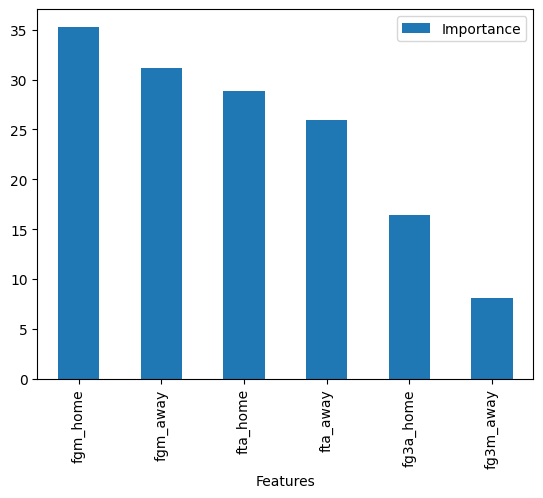

In [21]:
logistic_pipe = GRIDS_wo_pts["LogisticRegression"].best_estimator_


# This is an adapted version of the above function.
def feature_importance_logistic_regression(pipe, X_TrainSet, initial_drop):
    coefficients = pipe["LogisticRegression"].coef_[0]
    features, _ = find_features(X_TrainSet, logistic_pipe, initial_drop)
    importance_list = [
        (feature, X_TrainSet[feature].std() * coeff)
        for feature, coeff in zip(features, coefficients)
    ]
    df_feature_importance = pd.DataFrame(
        data={
            "Features": [term[0] for term in importance_list],
            "Importance": [abs(term[1]) for term in importance_list],
        }
    ).sort_values(by="Importance", ascending=False)

    best_features = df_feature_importance["Features"].to_list()

    # Most important features statement and plot
    print(
        f"* These are the {len(best_features)} most important features in "
        f"descending order. The model was trained on them: \n"
        f"{df_feature_importance['Features'].to_list()}"
    )

    df_feature_importance.plot(kind="bar", x="Features", y="Importance")

    for feature, coefficient in zip(features, coefficients):
        std = X_TrainSet[feature].std()
        print(feature, std * coefficient)

feature_importance_logistic_regression(logistic_pipe, X_TrainSet,
                                       initial_drop_wo_pts)

The most import features were made field goals. It is interesting that the made field goals of the away team was more important so often.

This analysis, determining what features the models gravitate towards, validates Hypothesis 1.

Let's remove all of the features that allow the models to directly compute part of the score and see how this impacts our models.

### Remove made shots

In [22]:
made_shots = ["ftm", "fgm", "fg3m"]
home_shots = [shot + "_home" for shot in made_shots]
away_shots = [shot + "_away" for shot in made_shots]
initial_drop_wo_made_shots = TRIVIAL + home_shots + away_shots

PIPELINES_wo_made_shots = create_pipelines(initial_drop_wo_made_shots)
GRIDS_wo_made_shots = grid_search(X_TrainSet, y_TrainSet, 
                                  PIPELINES_wo_made_shots)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END . accuracy: (test=0.848) precision: (test=0.865) total time=   1.0s
[CV 5/5] END . accuracy: (test=0.854) precision: (test=0.870) total time=   1.0s
[CV 2/5] END . accuracy: (test=0.841) precision: (test=0.858) total time=   1.1s
[CV 4/5] END . accuracy: (test=0.849) precision: (test=0.869) total time=   1.1s
[CV 3/5] END . accuracy: (test=0.846) precision: (test=0.861) total time=   1.1s
Finished with model 1.
6 models remaining.
### Beginning grid search for DecisionTree ###
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END . accuracy: (test=0.711) precision: (test=0.768) total time=   1.4s
[CV 3/5] END . accuracy: (test=0.686) precision: (test=0.744) total time=   1.4s
[CV 2/5] END . accuracy: (test=0.697) precision: (test=0.752) total time=   1.4s
[CV 1/5] END . accuracy: (test=0.687) precision: (test=0.746) total time=   1.4s
[CV 4/5] E

We have not yet begun to tune the hyperparameters and we are already exceeding our goals for Business Requirement 2. Logistic Regression continues to perform well and Decision Trees continue to lag behind. Still, this analysis validates Hypothesis 3 given how well our models are performing.

In [23]:
get_best_scores(GRIDS_wo_made_shots)

Best LogisticRegression model: Avg. Precision: 86.45458705012929%.
                               Avg. Accuracy: 84.7688948900069%.

Best DecisionTree model: Avg. Precision: 75.26401267227706%.
                         Avg. Accuracy: 69.6238375916609%.

Best RandomForest model: Avg. Precision: 80.10759657425007%.
                         Avg. Accuracy: 77.53756617671237%.

Best GradientBoosting model: Avg. Precision: 78.53503147654462%.
                             Avg. Accuracy: 76.86377585413172%.

Best ExtraTrees model: Avg. Precision: 74.9100302514023%.
                       Avg. Accuracy: 70.31195743316563%.

Best AdaBoost model: Avg. Precision: 83.17321719573727%.
                     Avg. Accuracy: 82.51521201210089%.

Best XGBoost model: Avg. Precision: 79.17513212775506%.
                    Avg. Accuracy: 76.8178956627536%.



In [24]:
print("LogisticRegression")
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    GRIDS_wo_made_shots["LogisticRegression"].best_estimator_,
    ["loss", "win"],
)
print("DecisionTree")
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    GRIDS_wo_made_shots["DecisionTree"].best_estimator_,
    ["loss", "win"],
)

LogisticRegression
#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       10740       2949
Prediction win         2354      18833


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.82      0.78      0.80     13689
         win       0.86      0.89      0.88     21187

    accuracy                           0.85     34876
   macro avg       0.84      0.84      0.84     34876
weighted avg       0.85      0.85      0.85     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2707        784
Prediction win          569       4659


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.83      0.78      0.80      3491
         win       0.86      0.89      0.87      5228

    accuracy                           0.84      8719
   macro avg       0.84      0.83   

The Decision Tree model overfit the data. It seems clear that the Logistic Regression models are best suited for our data.

Let's see which features were used and then which were found most important.

DecisionTree
* These are the 6 most important features in descending order. The model was trained on them: 
['ast_home', 'ast_away', 'fta_home', 'fta_away', 'reb_home', 'reb_away']


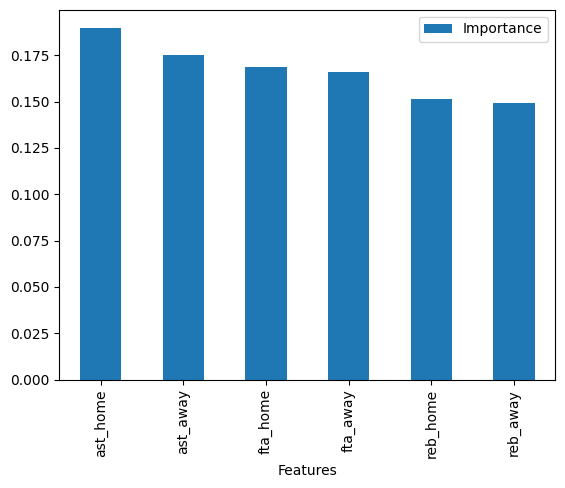

RandomForest
* These are the 6 most important features in descending order. The model was trained on them: 
['ast_home', 'ast_away', 'fta_home', 'fta_away', 'reb_home', 'reb_away']


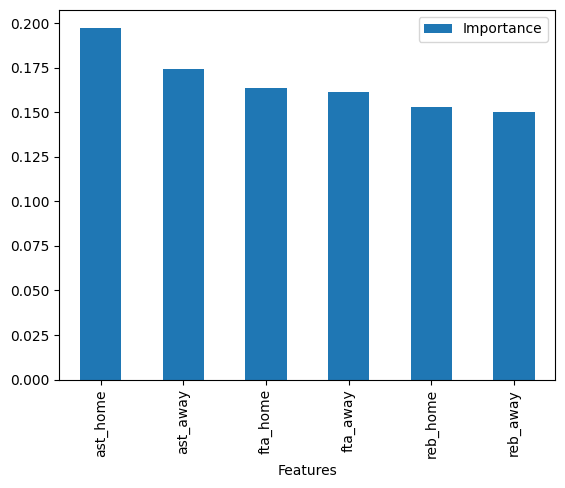

GradientBoosting
* These are the 5 most important features in descending order. The model was trained on them: 
['ast_home', 'ast_away', 'reb_away', 'reb_home', 'fta_home']


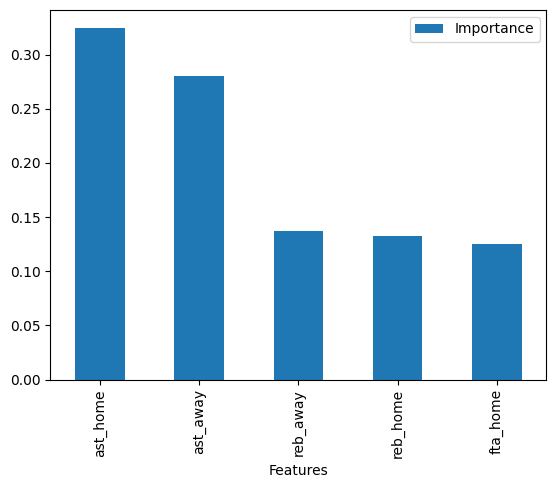

ExtraTrees
* These are the 4 most important features in descending order. The model was trained on them: 
['reb_home', 'reb_away', 'ast_home', 'ast_away']


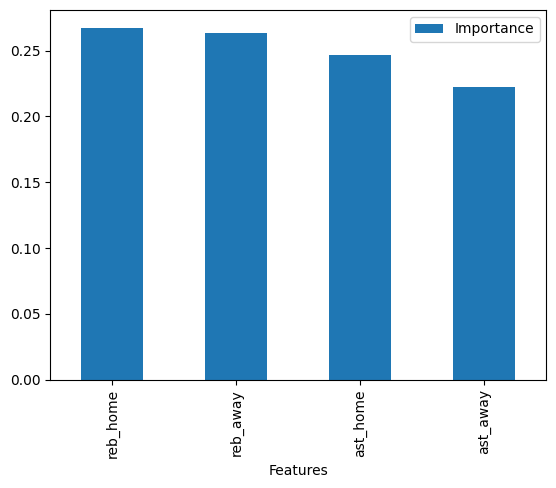

AdaBoost
* These are the 6 most important features in descending order. The model was trained on them: 
['reb_home', 'reb_away', 'oreb_home', 'oreb_away', 'tov_away', 'tov_home']


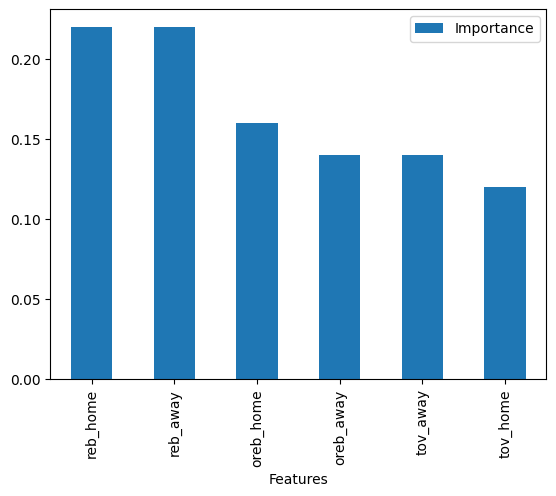

XGBoost
* These are the 6 most important features in descending order. The model was trained on them: 
['ast_home', 'ast_away', 'reb_away', 'reb_home', 'fta_home', 'tov_away']


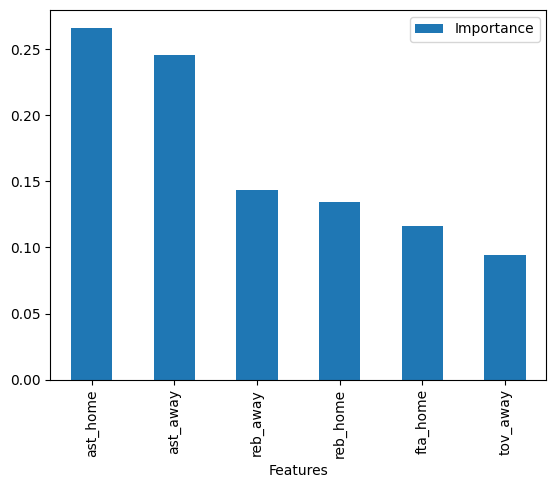

In [25]:
important_feature_report(GRIDS_wo_made_shots, X_TrainSet, 
                         initial_drop_wo_made_shots)

Extra Trees and Ada Boost found rebounds to be most valuable. The other tree based methods found assists to be most important. This makes sense as assists can be used as a proxy for made shots and rebounds can be used as a proxy for possession time.

Let's look at the Logistic Regression model.

* These are the 6 most important features in descending order. The model was trained on them: 
['reb_home', 'reb_away', 'oreb_home', 'oreb_away', 'tov_away', 'tov_home']
oreb_home -9.799613055145972
reb_home 21.18806287996657
tov_home -7.282148799745536
oreb_away 9.345846508096676
reb_away -20.347138956447978
tov_away 8.144363006867227


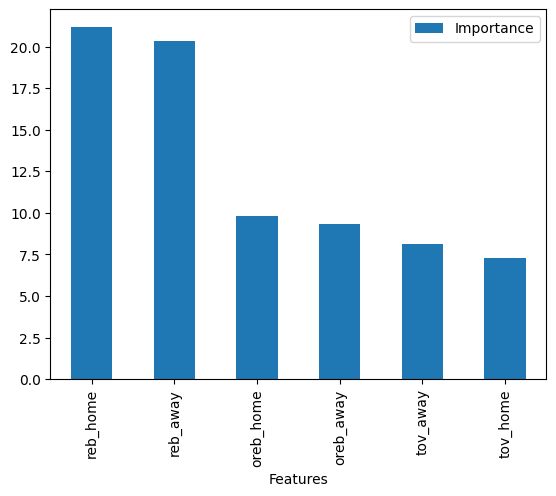

In [26]:
logistic_pipe = GRIDS_wo_made_shots["LogisticRegression"].best_estimator_
feature_importance_logistic_regression(
    logistic_pipe, X_TrainSet, initial_drop_wo_made_shots
)

So the Logistic Regression model valued rebounds very highly. Very interesting. We have found that both assists and rebounds are very valuable basketball statistics when made shots, the most obvious statistics, are removed from the analysis. Further, the models were still quite successful (without any tuning!!). This also addresses Business requirement 1 and Hytpothesis 2.

It is clear that we will tune the Logistic Regression model in the next notebook. But what other models should we tune? Let's look at the full reports on all of the models.

In [29]:
grid_search_report_best(
    GRIDS_wo_made_shots, X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, ["loss", "win"]
)

LogisticRegression
#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       10740       2949
Prediction win         2354      18833


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.82      0.78      0.80     13689
         win       0.86      0.89      0.88     21187

    accuracy                           0.85     34876
   macro avg       0.84      0.84      0.84     34876
weighted avg       0.85      0.85      0.85     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2707        784
Prediction win          569       4659


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.83      0.78      0.80      3491
         win       0.86      0.89      0.87      5228

    accuracy                           0.84      8719
   macro avg       0.84      0.83   

We want average precision to be above 75% and accuracy to be above 70%, and we only care about these scores on the test set. Also, recall that if the model performs much better on the training data, then it is overfit and will generalize poorly to unseen data.

* The Logistic Regression has an average precision of 84.5% and an accuracy of 84%. It performs almost identically on the training set, so it is not overfit.
* The Decision tree performs perfectly on the training set and then just fine on the test set. Thus it is overfit.
* The Random forest is also overfit for the same reason, even though it performs better than the Decision tree.
* The Gradient boosting model has an average precision of 76% and an accuracy of 76%. It is not overfit. 
* The Extra Trees is overfit.
* The AdaBoost model has an average precision of 82.5% and an accuracy of 82%. It performs nearly identically on the training set.
* The XGBoosting model has an average precision of 75.5% and an accuracy of 76%.

We will move forward looking at the Logistic Regression and AdaBoost models. We will save these two models for the next notebook.

In [28]:
import joblib


logistic_pipe = GRIDS_wo_made_shots["LogisticRegression"].best_estimator_
ada_pipe = GRIDS_wo_made_shots["AdaBoost"].best_estimator_

version = "v0"
file_path = f"outputs/ml_pipeline/predict_home_wins/{version}"
try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

joblib.dump(logistic_pipe, filename=f"{file_path}/logistic_pipeline.pkl")
joblib.dump(ada_pipe, filename=f"{file_path}/ada_pipeline.pkl")

['outputs/ml_pipeline/predict_home_wins/v0/ada_pipeline.pkl']


## Conclusions

* We have validated Hypothesis 1,  that the models will gravitate towards point related statistics when they are available.
* We found that total rebounds and assists are valuable statistics when point related statistics are unavailable. This is likely since an assist means the team made a shot and a rebound indicates possession of the ball. Also, defensive rebounds are more common than offensive rebounds. From the correlation matrices, we can compute that the correlation coefficient of rebounds with defensive rebounds is approximately 0.75 while the correlation of rebounds with offensive rebounds is approximately 0.54
* We have selected the Logistic Regression and Adaptive Boost models to move forward with.

## Next Steps
In the next notebook we will tune the hyperparameters of these models.